In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [2]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install xmltodict
!pip install s3fs
import s3fs
import xmltodict
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import matplotlib

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Register DPS algorithm
We need to register a DPS algorithm called 'do_HLS_stack_3-1-2' before proceeding to the chunks below...

In [12]:
!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_3-1-2/algorithm_config.yaml

{
  "algorithm_name": "do_HLS_stack_3-1-2",
  "code_version": "master",
  "environment_name": "ubuntu",
  "repo_url": "https://repo.ops.maap-project.org/icesat2_boreal/icesat2_boreal.git",
  "docker_container_url": "mas.dit.maap-project.org/root/maap-workspaces/base_images/vanilla:dit",
  "queue": "maap-dps-worker-16gb",
  "algorithm_description": "DPS run to create tiled HLS composites",
  "build_command": "icesat2_boreal/dps/build_command_main.sh",
  "script_command": "icesat2_boreal/dps/alg_3-1-2/run.sh",
  "disk_space": "16GB",
  "algorithm_params": [
    {
      "field": "in_tile_fn",
      "download": true
    },
    {
      "field": "in_tile_num",
      "download": false
    },
    {
      "field": "in_tile_layer",
      "download": false
    },
    {
      "field": "sat_api",
      "download": false
    },
    {
      "field": "tile_buffer_m",
      "download": false
    },
    {
      "field": "start_year",
      "download": false
    },
    {
      "field": "end_year",
      

# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [16]:
def GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS',
                    boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
                    GROUP_FIELD = 'tile_group',
                    tindex_master_fn = '/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',#'s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',
                    topo_tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
                    bad_tiles = [3540,3634,3728,3823,3916,4004], #Dropping the tiles near antimeridian that reproject poorly.
                    REMOVE_BAD_TILES = False,
                    REDO_TILES_LIST = None,
                    FIND_TILE_GROUP = None
                   ):

    # Get all boreal tiles
    #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
    boreal_tile_index = gpd.read_file(boreal_tile_index_path)
    
    if REMOVE_BAD_TILES:
        # Remove bad tiles
        boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

    hls_tindex_master = pd.read_csv(tindex_master_fn)
    topo_tindex_master = pd.read_csv(topo_tindex_master_fn)
    hls_tindex = boreal_tile_index.merge(hls_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    topo_tindex = boreal_tile_index.merge(topo_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    
    if REDO_TILES_LIST is not None:
        redo_hls_tindex = hls_tindex[hls_tindex['tile_num'].isin(REDO_TILES_LIST)]
        return redo_hls_tindex
    else:
        print(boreal_tile_index.groupby(GROUP_FIELD)[GROUP_FIELD].agg(['count']))

        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = [16, 16]

        print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
        print(f'\t# of boreal tiles in boreal v003:\t\t\t{len(boreal_tile_index)}')

        # Get water tiles
        water_tiles = list(set(boreal_tile_index.tile_num) - set(topo_tindex.tile_num) )
        print(f'\t# of boreal tiles in water:\t\t\t\t{len(water_tiles)}')

        NUM_STUDY_TILES = len(boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)])
        print(f'\t# of boreal tiles used study (from Topo coverage):\t{NUM_STUDY_TILES}')

        ax = boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)].plot(column=GROUP_FIELD, legend=True)
        #ax = tiles_topo_index.plot(color='gray', ax=ax)
        ax = hls_tindex.plot(color='black', ax = ax)
        print(f'\t# of boreal tiles with {DPS_DATA_TYPE}:\t\t\t\t{len(hls_tindex)}')

        needed_tindex = boreal_tile_index[~boreal_tile_index['tile_num'].isin(hls_tindex.tile_num.to_list() + water_tiles)]
        
        if FIND_TILE_GROUP is not None:
            needed_tindex = needed_tindex[needed_tindex[GROUP_FIELD] == FIND_TILE_GROUP]
        else:
            FIND_TILE_GROUP = 'all'
        LIST_TILES_NEEDED = needed_tindex.tile_num.to_list()
        print(f'\t# of boreal tiles still needing {DPS_DATA_TYPE} from {FIND_TILE_GROUP}:\t{len(LIST_TILES_NEEDED)}')
        # The next 100 tiles in line for processing
        #needed_tindex.iloc[0:100].plot(color='#525252', ax = ax)
        needed_tindex.plot(color='#525252', ax = ax)
        
        return LIST_TILES_NEEDED


In [35]:
RUN_ALL_TILES = True

if False:
    !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m_list 03 04 05

HLS_EXISTING_TINDEX_FN = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv'

if RUN_ALL_TILES:
    print('Running DPS on a ALL tiles from a previous tindex')
    hls_tindex_master = pd.read_csv(HLS_EXISTING_TINDEX_FN)
    HLS_TILES_NEEDED = hls_tindex_master.tile_num.to_list()
        
    print(f"List length: {len(HLS_TILES_NEEDED)}")
else:
    HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', tindex_master_fn = HLS_EXISTING_TINDEX_FN)
    #HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', FIND_TILE_GROUP = 'north america west', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')

Running DPS on a ALL tiles from a previous tindex
List length: 5245


In [36]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)

5245

#### Search for tiles that need to be redone due to artifacts
    + artifacts are scene-induced - where max_cloud = 25 was a bit too harsh
    + manually specify a redo tiles list after inspecting MS comps
    + delete the existing tile dirs for those tiles

In [37]:
if not RUN_ALL_TILES:
    REDO_TILES = [
                    1043, 1044, \
                    34675, 34674, 34676, 35126, 35125, 35352, 1216,
                    3193, 3286, 3380, 3938, 3949
                 ]

    REDO_TILES = [3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044, 3470]
    # Get the tindex of the REDOs
    redo_hls_tindex = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', REDO_TILES_LIST = REDO_TILES)

    if False:
        # Delete the tile dirs of the tiles needing a REDO
        for file in redo_hls_tindex.local_path.to_list():
            p = os.path.split(file)[0]
            print(p)
            !rm -rf $p
            
    INPUT_TILE_NUM_LIST = REDO_TILES
    print(INPUT_TILE_NUM_LIST)

In [38]:
DO_EXPERIMENT = False

In [39]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [40]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [41]:
# A strip across Siberia that can be improved with shorter seaonal window and broader cloud threshold?
if DO_EXPERIMENT:
    MISC_TILES = []
    INPUT_EXPERIMENT_TILE_NUM_LIST = list(range(1620,1657 + 1))
    print(len(INPUT_EXPERIMENT_TILE_NUM_LIST))

# Run a DPS of MS Composite tiles

In [3]:
#DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[2000:2100]
# 'mc40_06-01_09-15_2019_2021'
# 25_06-15_09-01_2019_2021
MAX_CLOUDS = 25 #35
SEASON_START = '06-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc25_06-15_09-01_2019_2021'

### Re-run this batch with same tile-specific composite params as spring2022


In [17]:
DO_MATCH_PREVIOUS_PARAMS = True

In [18]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_MATCH_PREVIOUS_PARAMS:
        print('Running DPS on the subset list with matched params')
        OUTPUT_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/spring2022/HLS_input_params.csv'
        df = pd.read_csv(OUTPUT_FN)
        DPS_INPUT_TILE_NUM_LIST = df[(df.max_cloud == MAX_CLOUDS) & 
                       (df.start_month_day ==SEASON_START) & 
                       (df.end_month_day == SEASON_STOP)
                      ].in_tile_num.to_list()
    elif DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the subset list with matched params
List length: 2225


In [23]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="master",
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE

    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 1443
DPS run #: 1	| tile num: 2822	| submit status: success	| job id: a1883b60-65bb-4e10-a608-d38681ecb532
DPS run #: 25	| tile num: 1674	| submit status: success	| job id: edfd1910-ea22-41d0-bd24-8e090527be29
DPS run #: 50	| tile num: 1556	| submit status: success	| job id: 3e038954-94c2-4761-bff7-2cce2f91e19d
DPS run #: 200	| tile num: 1522	| submit status: success	| job id: 54cc7802-9ffe-4225-ae23-bf8e2a6cf871
DPS run #: 300	| tile num: 1293	| submit status: success	| job id: bf3ca95f-f08f-4657-8ce2-f406e708030b
DPS run #: 400	| tile num: 1836	| submit status: success	| job id: ba1a2dc1-015d-4726-b658-e7562378a436
DPS run #: 500	| tile num: 739	| submit status: success	| job id: 419176ca-de2b-4f0d-ab77-f991e56863d0
DPS run #: 750	| tile num: 2304	| submit status: success	| job id: d9d6214b-cdcc-41c4-8c74-57af47476422
DPS run #: 1000	| tile num: 903	| submit status: success	| job id: 0ca93995-a030-4518-965c-0debbebd8f01
DPS run #: 1250	| tile num: 3679	| sub

,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,a1883b60-65bb-4e10-a608-d38681ecb532,1,2822,2022-10-14 12:13:19.197033,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,00ccbac7-e9ab-4f72-b87d-95e9cbec917d,2,2046,2022-10-14 12:13:19.281238,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,df8a02e3-f796-4082-8389-7a4c1a6543f1,3,1986,2022-10-14 12:13:19.379302,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,5a28185f-d121-473c-a643-5d5e4b608479,4,2123,2022-10-14 12:13:19.483963,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,bcc47f82-c166-4ea4-9277-e6f78533b66d,5,2084,2022-10-14 12:13:19.711652,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
...,...,...,...,...,...,...,...,...,...,...,...
0,success,200,c0da9ee8-4a60-4b0b-80f0-2384e50ba866,1439,37528,2022-10-14 12:18:46.171336,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,25ab8eb3-3de0-4592-83a3-9ec62c7733eb,1440,37962,2022-10-14 12:18:46.377485,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,45ca27db-13bc-43ff-abe2-fa01aa0eefe9,1441,37078,2022-10-14 12:18:46.571584,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021
0,success,200,fcbc78d3-921d-4c5b-b91b-cd885a512214,1442,37079,2022-10-14 12:18:46.773850,12,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [239]:
RUN_NAME

'mc25_06-15_09-01_2019_2021'

In [9]:
nowtime = '202210141218'
IDENTIFIER = "do_HLS_stack_3-1-2"

In [10]:
%%time
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
for DPS_DATETIME in [nowtime]:
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')

DPS alg:		do_HLS_stack_3-1-2
DPS launch time:	202210141218
Count total jobs:	1443
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	0
Count failed jobs:	1443
% of failed jobs:	100.0

CPU times: user 14.6 s, sys: 904 ms, total: 15.5 s
Wall time: 34.6 s


In [155]:
print(z[z['wps:Status'] =='Succeeded'].tile_num.to_list())

[34833, 35953, 36626, 36627, 36851, 37073, 37078, 37079]


### Get a list of the FAILS to run through DPS again

In [19]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()#[0:20]
len(DPS_INPUT_TILE_NUM_LIST)

1443

In [27]:
pd.DataFrame({'tile_num': DPS_INPUT_TILE_NUM_LIST}).to_csv('/projects/my-public-bucket/dps_submission_results/tmp_tile_list.csv')

In [53]:
z[z['wps:Status'] =='Failed']

,Unnamed: 0,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name,@xmlns:ows,@xmlns:schemaLocation,@xmlns:wps,@xmlns:xsi,wps:JobID,wps:Status
0,0,success,200,89747469-196d-49b7-98d4-0dafb18033f1,1,4441,2022-10-06 18:24:40.622528,18,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc40_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,89747469-196d-49b7-98d4-0dafb18033f1,Failed


In [198]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[50].job_id).content)

{'wps:Result': {'@xmlns:ows': 'http://www.opengis.net/ows/2.0',
  '@xmlns:schemaLocation': 'http://schemas.opengis.net/wps/2.0/wps.xsd',
  '@xmlns:wps': 'http://www.opengis.net/wps/2.0',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'wps:JobID': '0415b9a6-e9d9-4f6f-af6e-b85c4b36fc97',
  'wps:Output': {'@id': 'traceback',
   'wps:Data': '+ /app/icesat2_boreal/dps/alg_3-1-2/run.sh 3454 boreal_tiles_v003 https://cmr.earthdata.nasa.gov/stac/LPCLOUD 0 2019 2021 06-01 09-15 40 HLS\n+ unset PROJ_LIB\n+ mkdir output\n++ ls -d input/boreal_tiles_v003.gpkg\n+ FILENAMELIST=input/boreal_tiles_v003.gpkg\n+++ dirname /app/icesat2_boreal/dps/alg_3-1-2/run.sh\n++ cd /app/icesat2_boreal/dps/alg_3-1-2\n++ pwd -P\n+ basedir=/app/icesat2_boreal/dps/alg_3-1-2\n+ FILENAMELIST=($(ls -d input/*))\n++ ls -d input/boreal_tiles_v003.gpkg\n+ INPUT1=/data/work/jobs/2022/10/12/20/00/job-do_HLS_stack_3-1-2_ubuntu__master-20221012T195404.786825Z/input/boreal_tiles_v003.gpkg\n+ INPUT2=/data/work/jobs/

### Build a new tindex

In [7]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -alg_name 'do_HLS_stack_3-1-2_ubuntu' -t HLS -y 2022 -m 10 -d_min 12 --outdir '/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/fall2022_check'

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		['10']
Days:		12-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/fall2022_check
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3920_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_6_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3554_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/d

### Build mosaic json for mapping in folium

Building /projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/fall2022_check/HLS_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


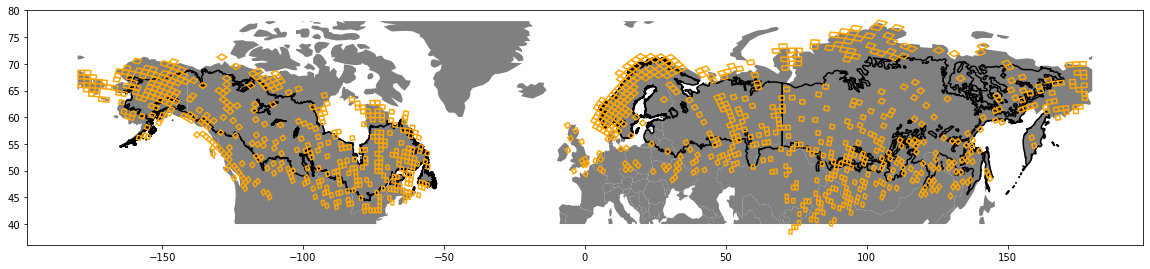

In [4]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

HLS_mosaic_json_fn_local, tile_index_matches_gdf = ExtractUtils.build_mosaic_json('/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/fall2022_check/HLS_tindex_master.csv', 
                       boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
                       BAD_TILE_LIST = BAD_TILE_LIST, 
                       cols_list = ['tile_num','s3_path','local_path'])

HLS_mosaic_json_fn = HLS_mosaic_json_fn_local.replace('/projects/my-public-bucket', 's3://maap-ops-workspace/shared/nathanmthomas')

# View the Results with Folium

### Spring 2022

In [ ]:
import maplib_folium
# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'
HLS_mosaic_json_fn_spring2022 = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_test_redo/spring2022/HLS_tindex_master_mosaic.json'

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_index_matches_gdf.tile_num.to_list())], 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin([4441])], 
                              MATCH_TILES_NAME='Tile matches',
                              CHECK_TILES_NAME='Tiles to check',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn,
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },
                            #MS_BANDNAME = 'NDVI',
                            MS_BANDNAME = 'NBR2',
                            MS_BANDMIN=0.25 ,
                            MS_BANDMAX=0.45 ,
                            #MS_BANDNUM=9, 
                            MS_BANDNUM=13, 
                            MS_BANDCOLORBAR='nipy_spectral',
                              map_width=1500, map_height=750
                             )

## Fall 2022

In [ ]:
import maplib_folium
# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_index_matches_gdf.tile_num.to_list())], 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin([4441])], 
                              MATCH_TILES_NAME='Tile matches',
                              CHECK_TILES_NAME='Tiles to check',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn,
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },
                            #MS_BANDNAME = 'NDVI',
                            MS_BANDNAME = 'NBR2',
                            MS_BANDMIN=0.25 ,
                            MS_BANDMAX=0.45 ,
                            #MS_BANDNUM=9, 
                            MS_BANDNUM=13, 
                            MS_BANDCOLORBAR='nipy_spectral',
                              map_width=1500, map_height=750
                             )

### The original spring 2022 HLS comp run types by tile
compositing requires trial and error to return tile composites that are free from cloud and seasonal artifacts  
these "run types" show the final set of compositing params used to return the composites for each tile

run_type
0_06-01_09-15_2019_2021        7
10_07-01_09-01_2019_2021     106
25_06-01_09-15_2019_2021    1255
25_06-15_09-01_2019_2021    2225
35_06-15_09-01_2019_2021     946
40_06-01_09-15_2019_2021     257
40_07-01_09-01_2019_2021     134
50_06-01_09-15_2019_2021      19
50_06-15_09-01_2019_2021     284
50_06-15_09-15_2019_2021      12
dtype: int64

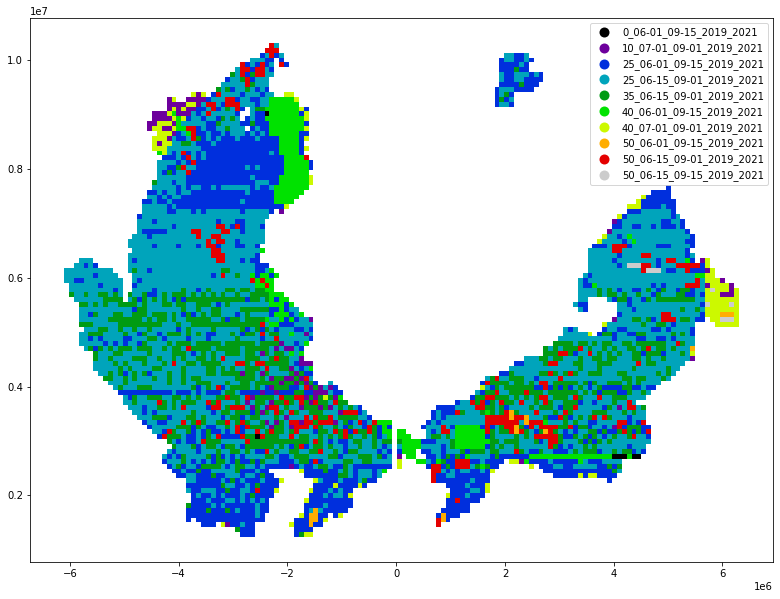

In [180]:
OUTPUT_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/spring2022/HLS_input_params.csv'
HLS_input_params_df = pd.read_csv(OUTPUT_FN)
HLS_input_params_df['run_type'] = HLS_input_params_df[['max_cloud','start_month_day','end_month_day','start_year','end_year']].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
HLS_input_params_df.head()

boreal_tile_index_HLS_input_params = boreal_tile_index.merge(HLS_input_params_df[['in_tile_num','run_type']], how='left', left_on='tile_num', right_on='in_tile_num')
boreal_tile_index_HLS_input_params.plot(column='run_type', cmap = "nipy_spectral", legend=True)
boreal_tile_index_HLS_input_params.groupby(['run_type']).size()